# ANN Regression Model for Q Factor Prediction

Goal: Predict **Q factor** from input parameters:
- radius
- frequency
- imaginary frequency

Steps:
1. Load and clean dataset
2. Handle NaN and extreme values
3. Define inputs and target (Q)
4. Scale inputs and output
5. Build and train ANN
6. Evaluate predictions


In [17]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import initializers
import os


In [19]:
# Step 2: Load and inspect the dataset
# Put Copy of exML1(1).xlsx in the same folder / upload to Colab.
file_path = "exML1(1).xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Clean column names (strip spaces)
df.columns = df.columns.str.strip()

# Quick look
print("Columns:", df.columns.tolist())
print("Rows:", df.shape[0])
display(df.head())


Columns: ['radius', 'frequency', 'imag. freq.', 'Q', '|amp|', 'amplitude', 'error']
Rows: 77


,radius,frequency,imag. freq.,Q,|amp|,amplitude,error
0,0.2,0.303599,0.000727,-208.772433,5.977912e+276,5.898855865278432e276+9.689864272809501e275i,1.3622452412096595e-6+0.0i
1,0.2,0.306301,-0.000527,290.514542,1.354148e+278,1.2603522241535274e278+4.952052369147027e277i,4.181223240497839e-7+0.0i
2,0.2,0.312268,0.000683,-228.567784,1.622379e+277,1.6010850177669324e277-2.619949857007207e276i,1.2519721680879213e-7+0.0i
3,0.2,0.336625,0.000388,-433.698119,3.468056e+277,-2.2126181175200236e277-2.6705306852810074e277i,8.634043648457769e-7+0.0i
4,0.2,0.463804,-0.000439,528.670965,7.386721e+276,-2.4136743861435043e276+6.981248192939019e276i,1.7662076385751583e-6+0.0i


In [20]:
# Step 3: Basic cleaning -> drop unusable columns, parse issues, handle NaNs
# We drop 'amplitude' and 'error' (strings/complex) because we won't use them for Q prediction.
cols_to_drop = [c for c in ['amplitude', 'error', '|amp|'] if c in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)

# Check NaNs
print("NaNs per column before cleaning:\n", df.isnull().sum())

# Option A: if only a few NaNs, drop them. Otherwise you may want to impute.
df = df.dropna(axis=0).reset_index(drop=True)

print("After dropna — rows:", df.shape[0])
print("NaNs per column now:\n", df.isnull().sum())

# Show basic stats for Q
if 'Q' in df.columns:
    display(df['Q'].describe())
else:
    raise RuntimeError("Column 'Q' not found in the sheet. Check column name.")


NaNs per column before cleaning:
 radius         0
frequency      0
imag. freq.    0
Q              0
dtype: int64
After dropna — rows: 77
NaNs per column now:
 radius         0
frequency      0
imag. freq.    0
Q              0
dtype: int64


count      77.000000
mean      289.482999
std      1145.107320
min     -1276.598324
25%      -117.433825
50%        70.236098
75%       320.426417
max      5937.684734
Name: Q, dtype: float64

In [21]:
# Step 4: Feature engineering (polynomial features up to 3rd power)
# Input features we will use: ['radius','frequency','imag. freq.']
# Add squared and cubic versions to help the NN capture non-linear relations.

df = df.copy()
feat_base = ['radius', 'frequency', 'imag. freq.']
for f in feat_base:
    df[f"{f}^2"] = df[f] ** 2
    df[f"{f}^3"] = df[f] ** 3

# Show the new columns
print("Feature columns available now:", [c for c in df.columns if c not in ['Q']][:20])
display(df.head())


Feature columns available now: ['radius', 'frequency', 'imag. freq.', 'radius^2', 'radius^3', 'frequency^2', 'frequency^3', 'imag. freq.^2', 'imag. freq.^3']


,radius,frequency,imag. freq.,Q,radius^2,radius^3,frequency^2,frequency^3,imag. freq.^2,imag. freq.^3
0,0.2,0.303599,0.000727,-208.772433,0.04,0.008,0.092172,0.027983,5.286805e-07,3.844058e-10
1,0.2,0.306301,-0.000527,290.514542,0.04,0.008,0.093820,0.028737,2.779072e-07,-1.465040e-10
2,0.2,0.312268,0.000683,-228.567784,0.04,0.008,0.097511,0.030450,4.666215e-07,3.187477e-10
3,0.2,0.336625,0.000388,-433.698119,0.04,0.008,0.113316,0.038145,1.506110e-07,5.845009e-11
4,0.2,0.463804,-0.000439,528.670965,0.04,0.008,0.215114,0.099771,1.924146e-07,-8.440280e-11


In [22]:
# Step 5: Prepare X and y
X_cols = [
    'radius', 'frequency', 'imag. freq.',
    'radius^2', 'frequency^2', 'imag. freq.^2',
    'radius^3', 'frequency^3', 'imag. freq.^3'
]
# Note: above column names must match exactly. If your sheet used different names, adapt them.
X = df[X_cols].values
y_raw = df[['Q']].values  # shape (N,1)

# Optional: inspect y range to decide on log-transform
print("Q range:", np.nanmin(y_raw), np.nanmax(y_raw))


Q range: -1276.59832406523 5937.68473419631


In [23]:
# Step 6: Stabilize target: log transform if Q spans wide range or has large outliers.
# We'll use log1p (log(1 + Q)) to allow Q=0 safely. If Q has negative values, we must handle them.
if np.any(y_raw <= -1):
    # negative values are tricky for log; let's shift if necessary by adding a constant:
    min_val = y_raw.min()
    shift = abs(min_val) + 1.0
    print(f"Q contains values <= -1. Shifting by {shift} before log1p.")
    y = np.log1p(y_raw + shift)
    y_shift_info = shift
else:
    y = np.log1p(y_raw)   # y = log(1 + Q)
    y_shift_info = 0.0

print("Transformed y shape:", y.shape)


Q contains values <= -1. Shifting by 1277.59832406523 before log1p.
Transformed y shape: (77, 1)


In [24]:
# Step 7: Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler_X = RobustScaler()  # robust to outliers
scaler_y = RobustScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes: (61, 9) (16, 9) (61, 1) (16, 1)


In [25]:
# Step 8: Build improved ANN model function (to reuse)
def build_model(input_dim, lr=5e-4, dropout_rate=0.2, init_std=0.05):
    init = initializers.RandomNormal(stddev=init_std)
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim, kernel_initializer=init),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(128, activation='relu', kernel_initializer=init),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(64, activation='relu', kernel_initializer=init),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(1, kernel_initializer=init)  # single output (transformed log-Q)
    ])
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

# Build the model
model = build_model(X_train.shape[1], lr=5e-4, dropout_rate=0.15, init_std=0.05)
model.summary()


c:\Users\dskum\Python\deeplearning\langchain\venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,305 (71.50 KB)

 Trainable params: 17,793 (69.50 KB)

 Non-trainable params: 512 (2.00 KB)

In [26]:
# Step 9: Callbacks for training
# Reduce LR when validation plateaus; early stop to avoid overfitting; checkpoint to save best model.
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_q_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]


In [27]:
# Step 10: Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.18,   # small portion of train used for val
    epochs=300,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 4.0922 - mse: 4.0922
Epoch 1: val_loss improved from None to 1.80279, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 2.6464 - mse: 2.6464 - val_loss: 1.8028 - val_mse: 1.8028 - learning_rate: 5.0000e-04
Epoch 2/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.7083 - mse: 1.7083
Epoch 2: val_loss improved from 1.80279 to 1.80185, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.3077 - mse: 2.3077 - val_loss: 1.8019 - val_mse: 1.8019 - learning_rate: 5.0000e-04
Epoch 3/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.0306 - mse: 2.0306
Epoch 3: val_loss did not improve from 1.80185
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1992 - mse: 2.1992 - val_loss: 1.8019 - val_mse: 1.8019 - learning_rate: 5.0000e-04
Epoch 4/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.1835 - mse: 3.1835
Epoch 4: val_loss did not improve from 1.80185
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.3406 - mse: 2.3406 - val_loss: 1.8019 - val_mse: 1.8019 - learning_rate: 5.0000e-04
Epoch 5/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.0075 - mse: 4.0075
Epoch 5: val_loss did not improve from 1.80185
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5492 - mse: 2.5492 - val_loss: 1.8024 - val_mse: 1.8024 - learning_rate: 5.0000e-04
Epoch 6/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.6777 - mse: 3.6777
Epoch 6: val_lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.2907 - mse: 2.2907 - val_loss: 1.8017 - val_mse: 1.8017 - learning_rate: 5.0000e-04
Epoch 8/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5993 - mse: 1.5993
Epoch 8: val_loss improved from 1.80166 to 1.80094, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.9717 - mse: 1.9717 - val_loss: 1.8009 - val_mse: 1.8009 - learning_rate: 5.0000e-04
Epoch 9/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6392 - mse: 0.6392
Epoch 9: val_loss did not improve from 1.80094
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.2828 - mse: 2.2828 - val_loss: 1.8013 - val_mse: 1.8013 - learning_rate: 5.0000e-04
Epoch 10/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.6854 - mse: 1.6854
Epoch 10: val_loss did not improve from 1.80094
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1928 - mse: 2.1928 - val_loss: 1.8018 - val_mse: 1.8018 - learning_rate: 5.0000e-04
Epoch 11/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3005 - mse: 0.3005
Epoch 11: val_loss did not improve from 1.80094
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.0214 - mse: 2.0214 - val_loss: 1.8018 - val_mse: 1.8018 - learning_rate: 5.0000e-04
Epoch 12/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.5930 - mse: 1.5930
Epoch 12: 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.7609 - mse: 1.7609 - val_loss: 1.8006 - val_mse: 1.8006 - learning_rate: 5.0000e-04
Epoch 15/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2496 - mse: 1.2496
Epoch 15: val_loss improved from 1.80060 to 1.80004, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.1155 - mse: 2.1155 - val_loss: 1.8000 - val_mse: 1.8000 - learning_rate: 5.0000e-04
Epoch 16/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.3040 - mse: 2.3040
Epoch 16: val_loss improved from 1.80004 to 1.79897, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.8245 - mse: 1.8245 - val_loss: 1.7990 - val_mse: 1.7990 - learning_rate: 5.0000e-04
Epoch 17/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.2693 - mse: 2.2693
Epoch 17: val_loss improved from 1.79897 to 1.79758, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.8346 - mse: 1.8346 - val_loss: 1.7976 - val_mse: 1.7976 - learning_rate: 5.0000e-04
Epoch 18/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.7592 - mse: 2.7592
Epoch 18: val_loss improved from 1.79758 to 1.79629, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.7768 - mse: 1.7768 - val_loss: 1.7963 - val_mse: 1.7963 - learning_rate: 5.0000e-04
Epoch 19/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.6479 - mse: 2.6479
Epoch 19: val_loss improved from 1.79629 to 1.79503, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.0548 - mse: 2.0548 - val_loss: 1.7950 - val_mse: 1.7950 - learning_rate: 5.0000e-04
Epoch 20/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8089 - mse: 1.8089
Epoch 20: val_loss improved from 1.79503 to 1.79413, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.9566 - mse: 1.9566 - val_loss: 1.7941 - val_mse: 1.7941 - learning_rate: 5.0000e-04
Epoch 21/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8594 - mse: 1.8594
Epoch 21: val_loss improved from 1.79413 to 1.79361, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.0690 - mse: 2.0690 - val_loss: 1.7936 - val_mse: 1.7936 - learning_rate: 5.0000e-04
Epoch 22/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9647 - mse: 0.9647
Epoch 22: val_loss improved from 1.79361 to 1.79328, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.9467 - mse: 1.9467 - val_loss: 1.7933 - val_mse: 1.7933 - learning_rate: 5.0000e-04
Epoch 23/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3729 - mse: 3.3729
Epoch 23: val_loss improved from 1.79328 to 1.79275, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.9263 - mse: 1.9263 - val_loss: 1.7927 - val_mse: 1.7927 - learning_rate: 5.0000e-04
Epoch 24/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.5534 - mse: 2.5534
Epoch 24: val_loss improved from 1.79275 to 1.79192, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.8651 - mse: 1.8651 - val_loss: 1.7919 - val_mse: 1.7919 - learning_rate: 5.0000e-04
Epoch 25/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1114 - mse: 1.1114
Epoch 25: val_loss improved from 1.79192 to 1.79020, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.7757 - mse: 1.7757 - val_loss: 1.7902 - val_mse: 1.7902 - learning_rate: 5.0000e-04
Epoch 26/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8448 - mse: 1.8448
Epoch 26: val_loss improved from 1.79020 to 1.78913, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5804 - mse: 1.5804 - val_loss: 1.7891 - val_mse: 1.7891 - learning_rate: 5.0000e-04
Epoch 27/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7774 - mse: 1.7774
Epoch 27: val_loss improved from 1.78913 to 1.78727, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6519 - mse: 1.6519 - val_loss: 1.7873 - val_mse: 1.7873 - learning_rate: 5.0000e-04
Epoch 28/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7793 - mse: 1.7793
Epoch 28: val_loss improved from 1.78727 to 1.78613, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.1548 - mse: 2.1548 - val_loss: 1.7861 - val_mse: 1.7861 - learning_rate: 5.0000e-04
Epoch 29/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.6646 - mse: 2.6646
Epoch 29: val_loss did not improve from 1.78613
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.2739 - mse: 2.2739 - val_loss: 1.7864 - val_mse: 1.7864 - learning_rate: 5.0000e-04
Epoch 30/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1451 - mse: 1.1451
Epoch 30: val_loss improved from 1.78613 to 1.78550, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.6528 - mse: 1.6528 - val_loss: 1.7855 - val_mse: 1.7855 - learning_rate: 5.0000e-04
Epoch 31/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8929 - mse: 0.8929
Epoch 31: val_loss did not improve from 1.78550
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0038 - mse: 2.0038 - val_loss: 1.7860 - val_mse: 1.7860 - learning_rate: 5.0000e-04
Epoch 32/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.2830 - mse: 2.2830
Epoch 32: val_loss did not improve from 1.78550
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9293 - mse: 1.9293 - val_loss: 1.7864 - val_mse: 1.7864 - learning_rate: 5.0000e-04
Epoch 33/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.4334 - mse: 3.4334
Epoch 33: val_loss did not improve from 1.78550
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1456 - mse: 2.1456 - val_loss: 1.7874 - val_mse: 1.7874 - learning_rate: 5.0000e-04
Epoch 34/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7013 - mse: 1.7013
Epoch 34

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.7495 - mse: 1.7495 - val_loss: 1.7852 - val_mse: 1.7852 - learning_rate: 2.5000e-04
Epoch 45/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.4647 - mse: 1.4647
Epoch 45: val_loss did not improve from 1.78520
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.5589 - mse: 1.5589 - val_loss: 1.7856 - val_mse: 1.7856 - learning_rate: 2.5000e-04
Epoch 46/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4790 - mse: 2.4790
Epoch 46: val_loss improved from 1.78520 to 1.78519, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5854 - mse: 1.5854 - val_loss: 1.7852 - val_mse: 1.7852 - learning_rate: 2.5000e-04
Epoch 47/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3099 - mse: 1.3099
Epoch 47: val_loss improved from 1.78519 to 1.78461, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.6785 - mse: 1.6785 - val_loss: 1.7846 - val_mse: 1.7846 - learning_rate: 2.5000e-04
Epoch 48/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5840 - mse: 1.5840
Epoch 48: val_loss improved from 1.78461 to 1.78407, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8137 - mse: 1.8137 - val_loss: 1.7841 - val_mse: 1.7841 - learning_rate: 2.5000e-04
Epoch 49/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6120 - mse: 0.6120
Epoch 49: val_loss improved from 1.78407 to 1.78378, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.7071 - mse: 1.7071 - val_loss: 1.7838 - val_mse: 1.7838 - learning_rate: 2.5000e-04
Epoch 50/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.8312 - mse: 2.8312
Epoch 50: val_loss did not improve from 1.78378
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9327 - mse: 1.9327 - val_loss: 1.7841 - val_mse: 1.7841 - learning_rate: 2.5000e-04
Epoch 51/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7180 - mse: 2.7180
Epoch 51: val_loss improved from 1.78378 to 1.78277, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.7323 - mse: 1.7323 - val_loss: 1.7828 - val_mse: 1.7828 - learning_rate: 2.5000e-04
Epoch 52/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6930 - mse: 1.6930
Epoch 52: val_loss improved from 1.78277 to 1.78167, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7381 - mse: 1.7381 - val_loss: 1.7817 - val_mse: 1.7817 - learning_rate: 2.5000e-04
Epoch 53/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6994 - mse: 1.6994
Epoch 53: val_loss improved from 1.78167 to 1.78030, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3315 - mse: 1.3315 - val_loss: 1.7803 - val_mse: 1.7803 - learning_rate: 2.5000e-04
Epoch 54/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.6297 - mse: 2.6297
Epoch 54: val_loss improved from 1.78030 to 1.77870, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.8709 - mse: 1.8709 - val_loss: 1.7787 - val_mse: 1.7787 - learning_rate: 2.5000e-04
Epoch 55/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5837 - mse: 0.5837
Epoch 55: val_loss improved from 1.77870 to 1.77711, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0921 - mse: 2.0921 - val_loss: 1.7771 - val_mse: 1.7771 - learning_rate: 2.5000e-04
Epoch 56/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8843 - mse: 1.8843
Epoch 56: val_loss improved from 1.77711 to 1.77622, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5310 - mse: 1.5310 - val_loss: 1.7762 - val_mse: 1.7762 - learning_rate: 2.5000e-04
Epoch 57/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7525 - mse: 0.7525
Epoch 57: val_loss improved from 1.77622 to 1.77453, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.9988 - mse: 1.9988 - val_loss: 1.7745 - val_mse: 1.7745 - learning_rate: 2.5000e-04
Epoch 58/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6876 - mse: 0.6876
Epoch 58: val_loss did not improve from 1.77453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4947 - mse: 1.4947 - val_loss: 1.7762 - val_mse: 1.7762 - learning_rate: 2.5000e-04
Epoch 59/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6002 - mse: 1.6002
Epoch 59: val_loss did not improve from 1.77453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9814 - mse: 1.9814 - val_loss: 1.7768 - val_mse: 1.7768 - learning_rate: 2.5000e-04
Epoch 60/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8718 - mse: 1.8718
Epoch 60: val_loss did not improve from 1.77453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1941 - mse: 2.1941 - val_loss: 1.7759 - val_mse: 1.7759 - learning_rate: 2.5000e-04
Epoch 61/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0296 - mse: 2.0296
Epoch 61

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6783 - mse: 1.6783 - val_loss: 1.7737 - val_mse: 1.7737 - learning_rate: 2.5000e-04
Epoch 62/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.5615 - mse: 1.5615
Epoch 62: val_loss improved from 1.77368 to 1.77209, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.2594 - mse: 1.2594 - val_loss: 1.7721 - val_mse: 1.7721 - learning_rate: 2.5000e-04
Epoch 63/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.2709 - mse: 1.2709
Epoch 63: val_loss improved from 1.77209 to 1.77000, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.8349 - mse: 1.8349 - val_loss: 1.7700 - val_mse: 1.7700 - learning_rate: 2.5000e-04
Epoch 64/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.9647 - mse: 1.9647
Epoch 64: val_loss improved from 1.77000 to 1.76623, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.6609 - mse: 1.6609 - val_loss: 1.7662 - val_mse: 1.7662 - learning_rate: 2.5000e-04
Epoch 65/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8981 - mse: 1.8981
Epoch 65: val_loss improved from 1.76623 to 1.76512, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.5468 - mse: 1.5468 - val_loss: 1.7651 - val_mse: 1.7651 - learning_rate: 2.5000e-04
Epoch 66/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7079 - mse: 0.7079
Epoch 66: val_loss improved from 1.76512 to 1.76288, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.8863 - mse: 1.8863 - val_loss: 1.7629 - val_mse: 1.7629 - learning_rate: 2.5000e-04
Epoch 67/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.4964 - mse: 1.4964
Epoch 67: val_loss improved from 1.76288 to 1.76090, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6690 - mse: 1.6690 - val_loss: 1.7609 - val_mse: 1.7609 - learning_rate: 2.5000e-04
Epoch 68/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8289 - mse: 2.8289
Epoch 68: val_loss improved from 1.76090 to 1.76050, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.9260 - mse: 1.9260 - val_loss: 1.7605 - val_mse: 1.7605 - learning_rate: 2.5000e-04
Epoch 69/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0100 - mse: 1.0100
Epoch 69: val_loss improved from 1.76050 to 1.75921, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.1116 - mse: 2.1116 - val_loss: 1.7592 - val_mse: 1.7592 - learning_rate: 2.5000e-04
Epoch 70/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8487 - mse: 1.8487
Epoch 70: val_loss improved from 1.75921 to 1.75820, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.8414 - mse: 1.8414 - val_loss: 1.7582 - val_mse: 1.7582 - learning_rate: 2.5000e-04
Epoch 71/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9935 - mse: 1.9935
Epoch 71: val_loss did not improve from 1.75820
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5314 - mse: 1.5314 - val_loss: 1.7584 - val_mse: 1.7584 - learning_rate: 2.5000e-04
Epoch 72/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.6113 - mse: 2.6113
Epoch 72: val_loss did not improve from 1.75820
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7307 - mse: 1.7307 - val_loss: 1.7606 - val_mse: 1.7606 - learning_rate: 2.5000e-04
Epoch 73/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8589 - mse: 1.8589
Epoch 73: val_loss did not improve from 1.75820
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6045 - mse: 1.6045 - val_loss: 1.7610 - val_mse: 1.7610 - learning_rate: 2.5000e-04
Epoch 74/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.3186 - mse: 2.3186
Epoch 74

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.4492 - mse: 1.4492 - val_loss: 1.7563 - val_mse: 1.7563 - learning_rate: 2.5000e-04
Epoch 76/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4212 - mse: 1.4212
Epoch 76: val_loss improved from 1.75625 to 1.75533, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.3907 - mse: 1.3907 - val_loss: 1.7553 - val_mse: 1.7553 - learning_rate: 2.5000e-04
Epoch 77/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.8926 - mse: 2.8926
Epoch 77: val_loss did not improve from 1.75533
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9210 - mse: 1.9210 - val_loss: 1.7555 - val_mse: 1.7555 - learning_rate: 2.5000e-04
Epoch 78/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2045 - mse: 1.2045
Epoch 78: val_loss improved from 1.75533 to 1.75511, saving model to best_q_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.1100 - mse: 1.1100 - val_loss: 1.7551 - val_mse: 1.7551 - learning_rate: 2.5000e-04
Epoch 79/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.4972 - mse: 2.4972
Epoch 79: val_loss did not improve from 1.75511
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.3189 - mse: 1.3189 - val_loss: 1.7573 - val_mse: 1.7573 - learning_rate: 2.5000e-04
Epoch 80/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5125 - mse: 1.5125
Epoch 80: val_loss did not improve from 1.75511
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7268 - mse: 1.7268 - val_loss: 1.7607 - val_mse: 1.7607 - learning_rate: 2.5000e-04
Epoch 81/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.3698 - mse: 2.3698
Epoch 81: val_loss did not improve from 1.75511
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6043 - mse: 1.6043 - val_loss: 1.7604 - val_mse: 1.7604 - learning_rate: 2.5000e-04
Epoch 82/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1892 - mse: 2.1892
Epoch 82

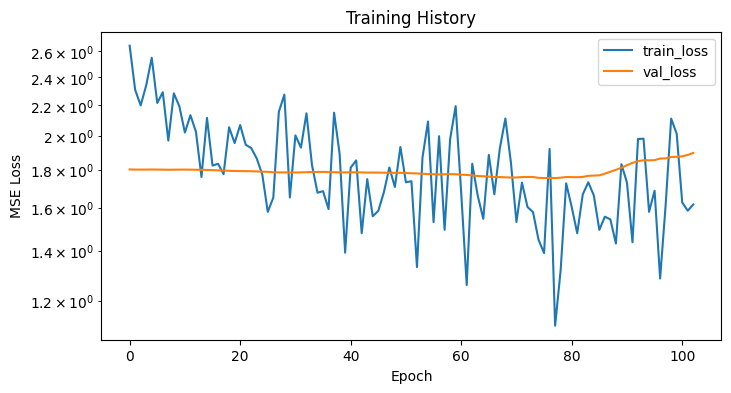

In [28]:
# Step 11: Plot training history (loss)
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')   # sometimes helpful
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.show()


In [29]:
# Step 12: Evaluate on test set and predict (inverse transforms included)
test_metrics = model.evaluate(X_test, y_test, verbose=0)
print("Test metrics (transformed-space):", test_metrics)

# Predictions in transformed (scaled) space
y_pred_scaled = model.predict(X_test)

# Inverse scale to original transformed target (log-space)
y_pred_transformed = scaler_y.inverse_transform(y_pred_scaled)
y_test_transformed = scaler_y.inverse_transform(y_test)

# Inverse log1p to actual Q (undo log1p and potential shift)
def inverse_log_transform(arr_transformed, shift=y_shift_info):
    arr_raw = np.expm1(arr_transformed)  # exp(arr)-1
    if shift != 0.0:
        arr_raw = arr_raw - shift
    return arr_raw

y_pred_Q = inverse_log_transform(y_pred_transformed)
y_test_Q = inverse_log_transform(y_test_transformed)

# Flatten for metrics
y_pred_Q = y_pred_Q.flatten()
y_test_Q = y_test_Q.flatten()


Test metrics (transformed-space): [27.923974990844727, 27.923974990844727]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [30]:
# Step 13: Metrics (real units)
mse_q = mean_squared_error(y_test_Q, y_pred_Q)
mae_q = mean_absolute_error(y_test_Q, y_pred_Q)
r2_q = r2_score(y_test_Q, y_pred_Q)

print("Q Prediction - Real units:")
print(f" MSE: {mse_q:.6f}")
print(f" MAE: {mae_q:.6f}")
print(f" R2 : {r2_q:.6f}")


Q Prediction - Real units:
 MSE: 249052.976494
 MAE: 332.046142
 R2 : 0.061974


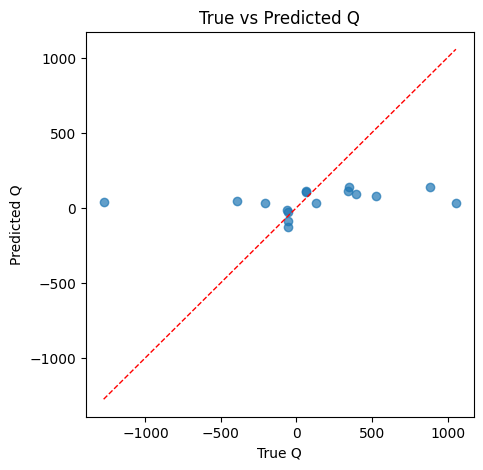

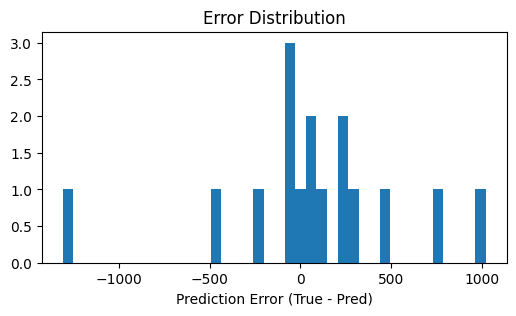

In [31]:
# Step 14: Visual checks (scatter + error histogram)
plt.figure(figsize=(5,5))
plt.scatter(y_test_Q, y_pred_Q, alpha=0.7)
mn, mx = min(y_test_Q.min(), y_pred_Q.min()), max(y_test_Q.max(), y_pred_Q.max())
plt.plot([mn,mx],[mn,mx],'r--', linewidth=1)
plt.xlabel('True Q')
plt.ylabel('Predicted Q')
plt.title('True vs Predicted Q')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(y_test_Q - y_pred_Q, bins=40)
plt.xlabel('Prediction Error (True - Pred)')
plt.title('Error Distribution')
plt.show()


In [32]:
# Step 15: Save final model and scalers for later use
model.save("final_q_model.h5")
import joblib
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")
print("Saved model and scalers.")


Saved model and scalers.


In [33]:
# Utility: function to predict Q from raw inputs easily
def predict_Q(radius, frequency, imag_freq, model, scaler_X, scaler_y, shift=y_shift_info):
    # Build feature vector same as training
    arr = np.array([[radius, frequency, imag_freq,
                     radius**2, frequency**2, imag_freq**2,
                     radius**3, frequency**3, imag_freq**3]])
    arr_s = scaler_X.transform(arr)
    y_scaled_pred = model.predict(arr_s)
    y_trans = scaler_y.inverse_transform(y_scaled_pred)
    q_pred = np.expm1(y_trans)  # inverse of log1p
    if shift != 0.0:
        q_pred = q_pred - shift
    return float(q_pred.flatten()[0])

# Example usage:
# loaded_model = model  # or use tf.keras.models.load_model('final_q_model.h5')
# loaded_scalerX = joblib.load("scaler_X.pkl")
# loaded_scalerY = joblib.load("scaler_y.pkl")
# print("Example prediction:", predict_Q(0.2, 0.303599, 0.000727, loaded_model, loaded_scalerX, loaded_scalerY))
